In [12]:
# 📒 E-commerce Customer Segmentation (RFM + KMeans)

# --- 1. Загрузка библиотек ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



## 1. Загрузка и агрегация данных
Загружаем данные о заказах, агрегируем их до уровня клиента и рассчитываем ключевые метрики:
- Recency (кол-во дней с последней покупки),
- Frequency (количество заказов),
- Monetary (сумма покупок),
- Средняя скидка, возвратность, время доставки,
- Демографические данные (возраст, пол, регион)

In [14]:
# Загрузка данных
df = pd.read_csv(r"D:\project\ecommerce_sales_34500.csv")
df["order_date"] = pd.to_datetime(df["order_date"])

# Агрегация на уровне клиента
grouped = df.groupby("customer_id").agg(
    recency_days=("order_date", lambda x: (pd.Timestamp.now() - x.max()).days),
    frequency=("order_id", "nunique"),
    avg_monetary=("total_amount", "sum"),
    avg_discount=("discount", "mean"),
    return_rate=('returned', lambda x: (x == 'Yes').mean()),
    avg_delivery=('delivery_time_days', 'mean'),
    age=('customer_age', 'first'),
    gender=('customer_gender', 'first'),
    region=('region', 'first')
).reset_index()

grouped.head()


,customer_id,recency_days,frequency,avg_monetary,avg_discount,return_rate,avg_delivery,age,gender,region
0,C10000,18,2,210.58,0.075000,0.0,4.000000,54,Male,North
1,C10001,207,5,3246.02,0.070000,0.0,4.800000,24,Female,North
2,C10002,414,5,216.85,0.130000,0.0,5.200000,51,Other,Central
3,C10003,85,3,154.30,0.016667,0.0,5.000000,38,Male,Central
4,C10004,613,3,716.99,0.000000,0.0,5.666667,22,Female,West



## 2. Подготовка признаков
- One-hot кодируем категориальные признаки,
- Масштабируем числовые признаки через StandardScaler.


In [16]:
# Кодирование категориальных признаков
df_encoded = pd.get_dummies(grouped, columns=["gender", "region"], drop_first=False)
df_encoded = df_encoded.drop(columns=["customer_id"])

# Числовые признаки
continuous_cols = [
    'recency_days', 'frequency', 'avg_monetary',
    'avg_discount', 'return_rate', 'avg_delivery', 'age'
]

# Масштабирование
scaler = StandardScaler()
df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])


## 3. Определение оптимального числа кластеров
Перебираем K от 2 до 10 и считаем **Silhouette Score** для оценки качества кластеризации.


In [18]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans.fit_predict(df_encoded)
    score = silhouette_score(df_encoded, labels_temp)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

# Оптимальное K
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n Оптимальное число кластеров: {optimal_k}")


K=2, Silhouette Score: 0.1139
K=3, Silhouette Score: 0.1071
K=4, Silhouette Score: 0.1206
K=5, Silhouette Score: 0.1109
K=6, Silhouette Score: 0.1149
K=7, Silhouette Score: 0.1144
K=8, Silhouette Score: 0.1099
K=9, Silhouette Score: 0.0977
K=10, Silhouette Score: 0.0995

 Оптимальное число кластеров: 4


## 4. Финальная кластеризация
Строим модель KMeans с оптимальным числом кластеров и анализируем средние значения признаков в каждом сегменте.


In [24]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_encoded)

grouped['cluster'] = labels
rfm_means = grouped.groupby('cluster')[[
    'recency_days', 'frequency', 'avg_monetary', 'avg_discount', 'avg_delivery'
]].mean()

print("\n Средние значения по кластерам:")
display(rfm_means.round(2))

print("\n Распределение клиентов по кластерам:")
cluster_counts = pd.Series(labels).value_counts().sort_index()
display(cluster_counts)



 Средние значения по кластерам:


,recency_days,frequency,avg_monetary,avg_discount,avg_delivery
cluster,,,,,
0,172.98,4.05,568.97,0.05,4.84
1,415.57,2.49,372.07,0.05,4.84
2,116.67,3.80,455.73,0.05,4.79
3,100.87,6.84,1602.78,0.05,4.83



 Распределение клиентов по кластерам:


0    1047
1    1370
2    3516
3    1970
Name: count, dtype: int64

## 5. Визуализация результатов
- График зависимости Silhouette Score от числа кластеров,
- Диаграмма распределения клиентов по сегментам.


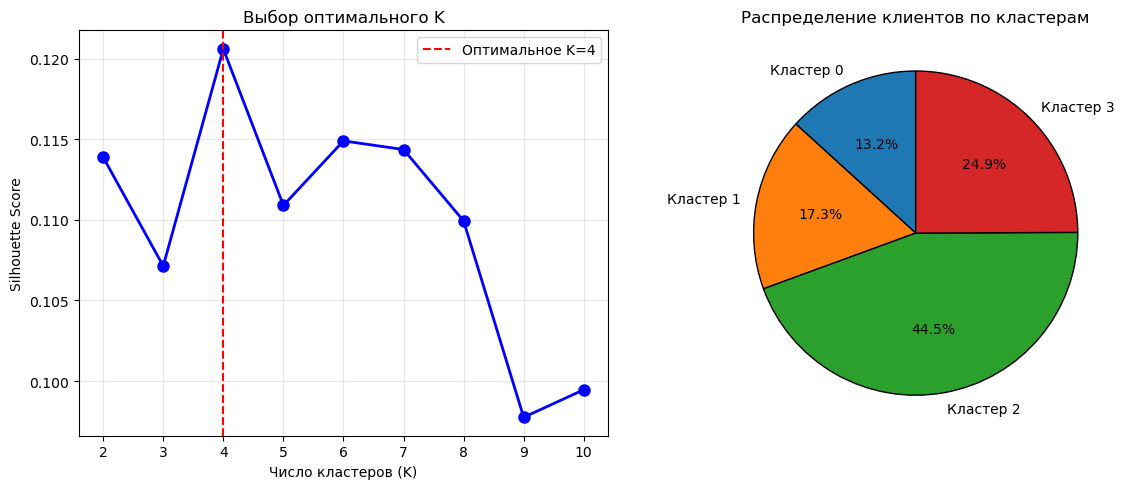

In [26]:
plt.figure(figsize=(12, 5))

# Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Оптимальное K={optimal_k}')
plt.xlabel('Число кластеров (K)')
plt.ylabel('Silhouette Score')
plt.title('Выбор оптимального K')
plt.legend()
plt.grid(True, alpha=0.3)

# Pie chart
plt.subplot(1, 2, 2)
cluster_names = [f'Кластер {i}' for i in range(optimal_k)]
colors = plt.cm.tab10.colors[:optimal_k]
plt.pie(
    cluster_counts,
    labels=cluster_names,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Распределение клиентов по кластерам')

plt.tight_layout()
plt.show()


Полученные сегменты:

Кластер 0 – Спящие клиенты: давно не покупали (172 дня с последнего заказа), низкая частота (4 заказа), средний чек средний (~569). Требуют кампаний на реанимацию.

Кластер 1 – Потерянные клиенты: очень давно неактивны (415 дней), низкая частота (2.5 заказа), маленький средний чек (~372). Практически ушедшие.

Кластер 2 – Активные средние: относительно свежие (117 дней), средняя частота (3.8 заказа), средний чек умеренный (~456). Основная масса «нормальных» покупателей.

Кластер 3 – VIP: самые активные (100 дней), высокая частота (6.8 заказа), очень высокий средний чек (~1603). Ядро бизнеса, нуждаются в персональных предложениях и удержании.

Результат:
Сегментация позволила разделить клиентов на четыре ключевые группы:

VIP → приоритет для персонализации и бонусных программ.

Активные средние → можно конвертировать в VIP через апселлы и рекомендации.

Спящие → нужны кампании на возвращение.

Потерянные → минимальная отдача, только массовый маркетинг.